# Question: Which factor(s) is most correlated with youth marijuana use?

In [1]:
# import statements at top to keep things more organized
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from sklearn.tree import plot_tree

In [2]:
data = pd.read_csv('youth_data.csv')
data.head()

,IRALCFY,IRMJFY,IRCIGFM,IRSMKLSS30N,IRALCFM,IRMJFM,IRCIGAGE,IRSMKLSSTRY,IRALCAGE,IRMJAGE,...,EDUSCHLGO,EDUSCHGRD2,EDUSKPCOM,IMOTHER,IFATHER,INCOME,GOVTPROG,POVERTY3,PDEN10,COUTYP4
0,991,991,91.0,91,91.0,91.0,991,991,991,991,...,1,3,0,1,1,2,2,1,2,2
1,991,60,91.0,91,91.0,2.0,991,991,991,14,...,1,6,0,1,1,2,2,1,2,2
2,1,991,91.0,91,93.0,91.0,991,991,11,991,...,1,2,1,1,1,4,2,3,1,1
3,991,991,91.0,91,91.0,91.0,991,991,991,991,...,1,2,0,1,1,3,2,2,1,1
4,991,991,91.0,91,91.0,91.0,991,991,991,991,...,1,5,0,1,1,4,2,3,2,2


In [3]:
data.shape

(10561, 79)

In [4]:
data.columns

Index(['IRALCFY', 'IRMJFY', 'IRCIGFM', 'IRSMKLSS30N', 'IRALCFM', 'IRMJFM',
       'IRCIGAGE', 'IRSMKLSSTRY', 'IRALCAGE', 'IRMJAGE', 'MRJFLAG', 'ALCFLAG',
       'TOBFLAG', 'ALCYDAYS', 'MRJYDAYS', 'ALCMDAYS', 'MRJMDAYS', 'CIGMDAYS',
       'SMKLSMDAYS', 'SCHFELT', 'TCHGJOB', 'AVGGRADE', 'STNDSCIG', 'STNDSMJ',
       'STNDALC', 'STNDDNK', 'PARCHKHW', 'PARHLPHW', 'PRCHORE2', 'PRLMTTV2',
       'PARLMTSN', 'PRGDJOB2', 'PRPROUD2', 'ARGUPAR', 'YOFIGHT2', 'YOGRPFT2',
       'YOHGUN2', 'YOSELL2', 'YOSTOLE2', 'YOATTAK2', 'PRPKCIG2', 'PRMJEVR2',
       'PRMJMO', 'PRALDLY2', 'YFLPKCG2', 'YFLTMRJ2', 'YFLMJMO', 'YFLADLY2',
       'FRDPCIG2', 'FRDMEVR2', 'FRDMJMON', 'FRDADLY2', 'TALKPROB', 'PRTALK3',
       'PRBSOLV2', 'PREVIOL2', 'PRVDRGO2', 'GRPCNSL2', 'PREGPGM2', 'YTHACT2',
       'DRPRVME3', 'ANYEDUC3', 'RLGATTD', 'RLGIMPT', 'RLGDCSN', 'RLGFRND',
       'IRSEX', 'NEWRACE2', 'HEALTH2', 'EDUSCHLGO', 'EDUSCHGRD2', 'EDUSKPCOM',
       'IMOTHER', 'IFATHER', 'INCOME', 'GOVTPROG', 'POVERTY3', 'PDEN10',

In [5]:
# features of interest
# I grouped them into categories which I think might have an influence
edu = ['AVGGRADE', 'EDUSCHLGO', 'EDUSCHGRD2', 'EDUSKPCOM']
family = ['PARCHKHW', 'PARHLPHW', 'PRCHORE2', 'PRLMTTV2', 'PARLMTSN', 'PRGDJOB2', 'PRPROUD2', 'ARGUPAR']
peer = ['FRDMEVR2', 'FRDMJMON']
mental_health = ['SCHFELT', 'TALKPROB', 'PRTALK3', 'PRBSOLV2', 'PREVIOL2', 'PRVDRGO2', 'GRPCNSL2', 'PREGPGM2']
demographics = ['IRSEX', 'NEWRACE2', 'HEALTH2', 'IMOTHER', 'IFATHER', 'INCOME', 'GOVTPROG', 'POVERTY3', 'PDEN10', 'COUTYP4']

# target variables
target = ['MRJFLAG', 'MRJYDAYS', 'MRJMDAYS']

In [6]:
data = data[(edu + family + peer + mental_health + demographics + target)]
data.head()

,AVGGRADE,EDUSCHLGO,EDUSCHGRD2,EDUSKPCOM,PARCHKHW,PARHLPHW,PRCHORE2,PRLMTTV2,PARLMTSN,PRGDJOB2,...,IMOTHER,IFATHER,INCOME,GOVTPROG,POVERTY3,PDEN10,COUTYP4,MRJFLAG,MRJYDAYS,MRJMDAYS
0,2.0,1,3,0,1.0,1.0,1.0,2.0,1.0,1.0,...,1,1,2,2,1,2,2,0,6,5
1,2.0,1,6,0,1.0,1.0,2.0,2.0,1.0,1.0,...,1,1,2,2,1,2,2,1,3,1
2,2.0,1,2,1,1.0,1.0,1.0,1.0,1.0,2.0,...,1,1,4,2,3,1,1,0,6,5
3,NaN,1,2,0,1.0,2.0,2.0,2.0,2.0,1.0,...,1,1,3,2,2,1,1,0,6,5
4,2.0,1,5,0,2.0,1.0,1.0,2.0,2.0,1.0,...,1,1,4,2,3,2,2,0,6,5


In [7]:
data.columns

Index(['AVGGRADE', 'EDUSCHLGO', 'EDUSCHGRD2', 'EDUSKPCOM', 'PARCHKHW',
       'PARHLPHW', 'PRCHORE2', 'PRLMTTV2', 'PARLMTSN', 'PRGDJOB2', 'PRPROUD2',
       'ARGUPAR', 'FRDMEVR2', 'FRDMJMON', 'SCHFELT', 'TALKPROB', 'PRTALK3',
       'PRBSOLV2', 'PREVIOL2', 'PRVDRGO2', 'GRPCNSL2', 'PREGPGM2', 'IRSEX',
       'NEWRACE2', 'HEALTH2', 'IMOTHER', 'IFATHER', 'INCOME', 'GOVTPROG',
       'POVERTY3', 'PDEN10', 'COUTYP4', 'MRJFLAG', 'MRJYDAYS', 'MRJMDAYS'],
      dtype='object')

In [8]:
# rename the columns to be more interpretable and readable later on when plotting and such
data.columns = [
    'Avg_Grades',                # AVGGRADE
    'School_Attendance',         # EDUSCHLGO
    'Highest_Grade',             # EDUSCHGRD2
    'School_Problems_Comm',      # EDUSKPCOM
    'Parent_Checks_Homework',    # PARCHKHW
    'Parent_Helps_Homework',     # PARHLPHW
    'Does_Chores',               # PRCHORE2
    'Limited_TV_Time',           # PRLMTTV2
    'Parents_Set_Limits',        # PARLMTSN
    'Good_Job_Approval',         # PRGDJOB2
    'Parent_Pride',              # PRPROUD2
    'Parent_Arguments',          # ARGUPAR
    'Friend_Offered_Drugs',      # FRDMEVR2
    'Friends_Use_Marijuana',     # FRDMJMON
    'School_Felt_Unsafe',        # SCHFELT
    'Talked_About_Problems',     # TALKPROB
    'Can_Talk_To_Parents',       # PRTALK3
    'Problem_Solving_Support',   # PRBSOLV2
    'Violent_Peer_Influence',    # PREVIOL2
    'Private_Doctor_Visits',     # PRVDRGO2
    'Group_Counseling',          # GRPCNSL2
    'Pregnancy_Program',         # PREGPGM2
    'Sex',                       # IRSEX
    'Race',                      # NEWRACE2
    'Health_Status',             # HEALTH2
    'Mother_Present',            # IMOTHER
    'Father_Present',            # IFATHER
    'Household_Income',          # INCOME
    'Govt_Assistance_Use',       # GOVTPROG
    'Poverty_Level',             # POVERTY3
    'Population_Density',        # PDEN10
    'County_Type',               # COUTYP4
    'Used_Marijuana_Flag',       # MRJFLAG (target, binary)
    'Days_Used_This_Year',       # MRJYDAYS (target, reg)
    'Days_Used_This_Month'       # MRJMDAYS (target, multiclass)
]

In [9]:
# check for null/missing values
print(data.isna().sum().tolist())

[716, 0, 0, 0, 77, 89, 35, 68, 259, 63, 77, 180, 152, 152, 0, 336, 199, 286, 142, 102, 120, 98, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
data.shape, data.dropna().shape
# if we drop rows with missing values, we lose too much data (~10%) so impute instead

((10561, 35), (8967, 35))

In [11]:
set(data.dtypes) # we only have numerical data types so just impute with mean/mode

{dtype('int64'), dtype('float64')}

In [12]:
# impute
for col in list(data.columns):
    if data[col].isna().sum() > 0:
        if col == 'Avg_Grades':
            data[col] = data[col].fillna(data[col].mean())
        else:
            data[col] = data[col].fillna(data[col].mode()[0])

In [13]:
data.head()

,Avg_Grades,School_Attendance,Highest_Grade,School_Problems_Comm,Parent_Checks_Homework,Parent_Helps_Homework,Does_Chores,Limited_TV_Time,Parents_Set_Limits,Good_Job_Approval,...,Mother_Present,Father_Present,Household_Income,Govt_Assistance_Use,Poverty_Level,Population_Density,County_Type,Used_Marijuana_Flag,Days_Used_This_Year,Days_Used_This_Month
0,2.000000,1,3,0,1.0,1.0,1.0,2.0,1.0,1.0,...,1,1,2,2,1,2,2,0,6,5
1,2.000000,1,6,0,1.0,1.0,2.0,2.0,1.0,1.0,...,1,1,2,2,1,2,2,1,3,1
2,2.000000,1,2,1,1.0,1.0,1.0,1.0,1.0,2.0,...,1,1,4,2,3,1,1,0,6,5
3,1.941696,1,2,0,1.0,2.0,2.0,2.0,2.0,1.0,...,1,1,3,2,2,1,1,0,6,5
4,2.000000,1,5,0,2.0,1.0,1.0,2.0,2.0,1.0,...,1,1,4,2,3,2,2,0,6,5


In [14]:
for col in list(data.columns):
    print(data[col].value_counts())

Avg_Grades
2.000000    9271
1.941696     716
1.000000     574
Name: count, dtype: int64
School_Attendance
1     9378
2      999
94      85
97      46
11      22
85      21
98      10
Name: count, dtype: int64
Highest_Grade
5     1704
6     1673
4     1589
7     1584
3     1370
99     999
8      902
2      451
98     195
9       65
1       26
10       3
Name: count, dtype: int64
School_Problems_Comm
0     5801
99    2355
1      685
2      428
98     322
3      219
4      145
5      129
94     115
10      58
7       46
18      39
6       32
30      22
15      21
8       20
97      18
20      16
9       16
12      14
13      11
25      10
14       8
17       6
21       5
23       5
11       4
28       3
19       2
27       2
24       2
16       1
22       1
Name: count, dtype: int64
Parent_Checks_Homework
1.0    8392
2.0    2169
Name: count, dtype: int64
Parent_Helps_Homework
1.0    8240
2.0    2321
Name: count, dtype: int64
Does_Chores
1.0    9266
2.0    1295
Name: count, dtype: int64
Li

## Binary Classifcation using Decision Tree Classifier

In [15]:
# split train and test
train = data.drop(columns = ['Used_Marijuana_Flag', 'Days_Used_This_Year', 'Days_Used_This_Month'])
test = data['Used_Marijuana_Flag']
x_train, x_test, y_train, y_test = train_test_split(train, test, test_size = .2, random_state = 5322)

In [16]:
param_grid = {
    'max_depth': [3, 5, 10, 20, x_train.shape[1]],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

binary_dt = DecisionTreeClassifier(random_state = 5322)
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 5322)
grid_search = GridSearchCV(
    estimator = binary_dt,
    param_grid = param_grid,
    cv = cv,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1
)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5322, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=5322), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [3, 5, 10, 20, 32],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 5, 10]},
             scoring='f1', verbose=1)

In [17]:
grid_search.best_params_

{'class_weight': 'balanced',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [18]:
best_binary_dt = grid_search.best_estimator_

binary_dt_pred = best_binary_dt.predict(x_test)
print(classification_report(y_test, binary_dt_pred, target_names = ["Never Used", "Used"]))

              precision    recall  f1-score   support

  Never Used       0.92      0.90      0.91      1781
        Used       0.52      0.60      0.55       332

    accuracy                           0.85      2113
   macro avg       0.72      0.75      0.73      2113
weighted avg       0.86      0.85      0.85      2113



Class 0 (No marijuana used ever):
- Precision: .92 --> Of all the people predicted as non-users of marijuana, 92% were actually non-users. This means our model is good at identifying non-users. Few false positives
- Recall: .90 --> Of all the actual non-users, 90% were correctly identified as non-users. This means our model is good at catching non-users. Few false negatives.
- F1-score: .91 --> Suggests the model is good at identifying non-users

Class 1 (Used marijuana):
- Precision: .52 --> Of all the people predicted to be users of marijuana, only 52% were actually users. This means the model is not good at identifying users of marijuana. Some false positives
- Recall: .60 --> Of all the actual marijuana users, 60% were correctly identified. This means the model is not good at catching users. Some false negatives.
- F1-score: .55 --> Suggests model struggles with identifying users of marijuana.

Accuracy: .85 --> 85% is a good accuracy, but it is a little midleading since our data has very clear class imbalance. Far more people who have not used versus used, so our model does well on non-users, but very poorly on users.

In [19]:
print(cross_val_score(
    estimator = best_binary_dt,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 0
))
# There is a little bit of variance in the f1 cv scores. stable model.

[0.52268603 0.55421687 0.52064632 0.57443082 0.47654784]


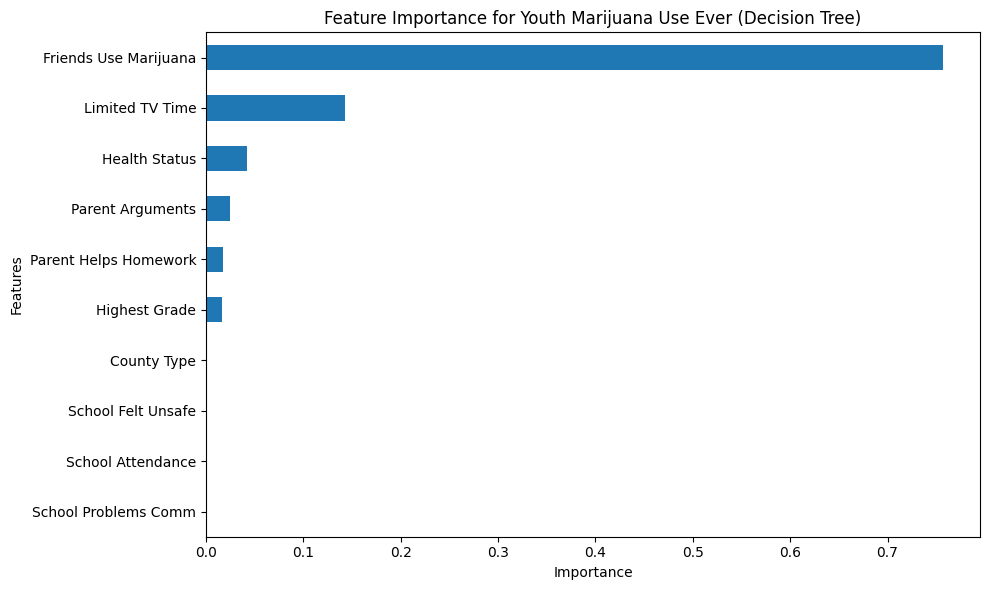

In [20]:
# see which features are most influential
importances = pd.Series(
    best_binary_dt.feature_importances_, 
    index = x_train.columns.str.replace('_', ' ')
).sort_values(ascending = True)

plt.figure(figsize = (10, 6))
importances.tail(10).plot(kind = 'barh')
plt.title("Feature Importance for Youth Marijuana Use Ever (Decision Tree)")
plt.ylabel("Features")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

Friends Use Marijuana is the most influential factor by far. Peer pressure is real I guess. The others were mostly pretty intuitive or things you have heard or read about in papers (parents argue, problems with school, etc.). The only surprising factor was Parent Helps Homework. Smoking marijuana depending on whether your parents helped you on your homework seems a very weird. Limited TV Time was also somewhat surprising, but I figured if you watch a lot of tv shows where the main characters use drugs could definitely have an influence.

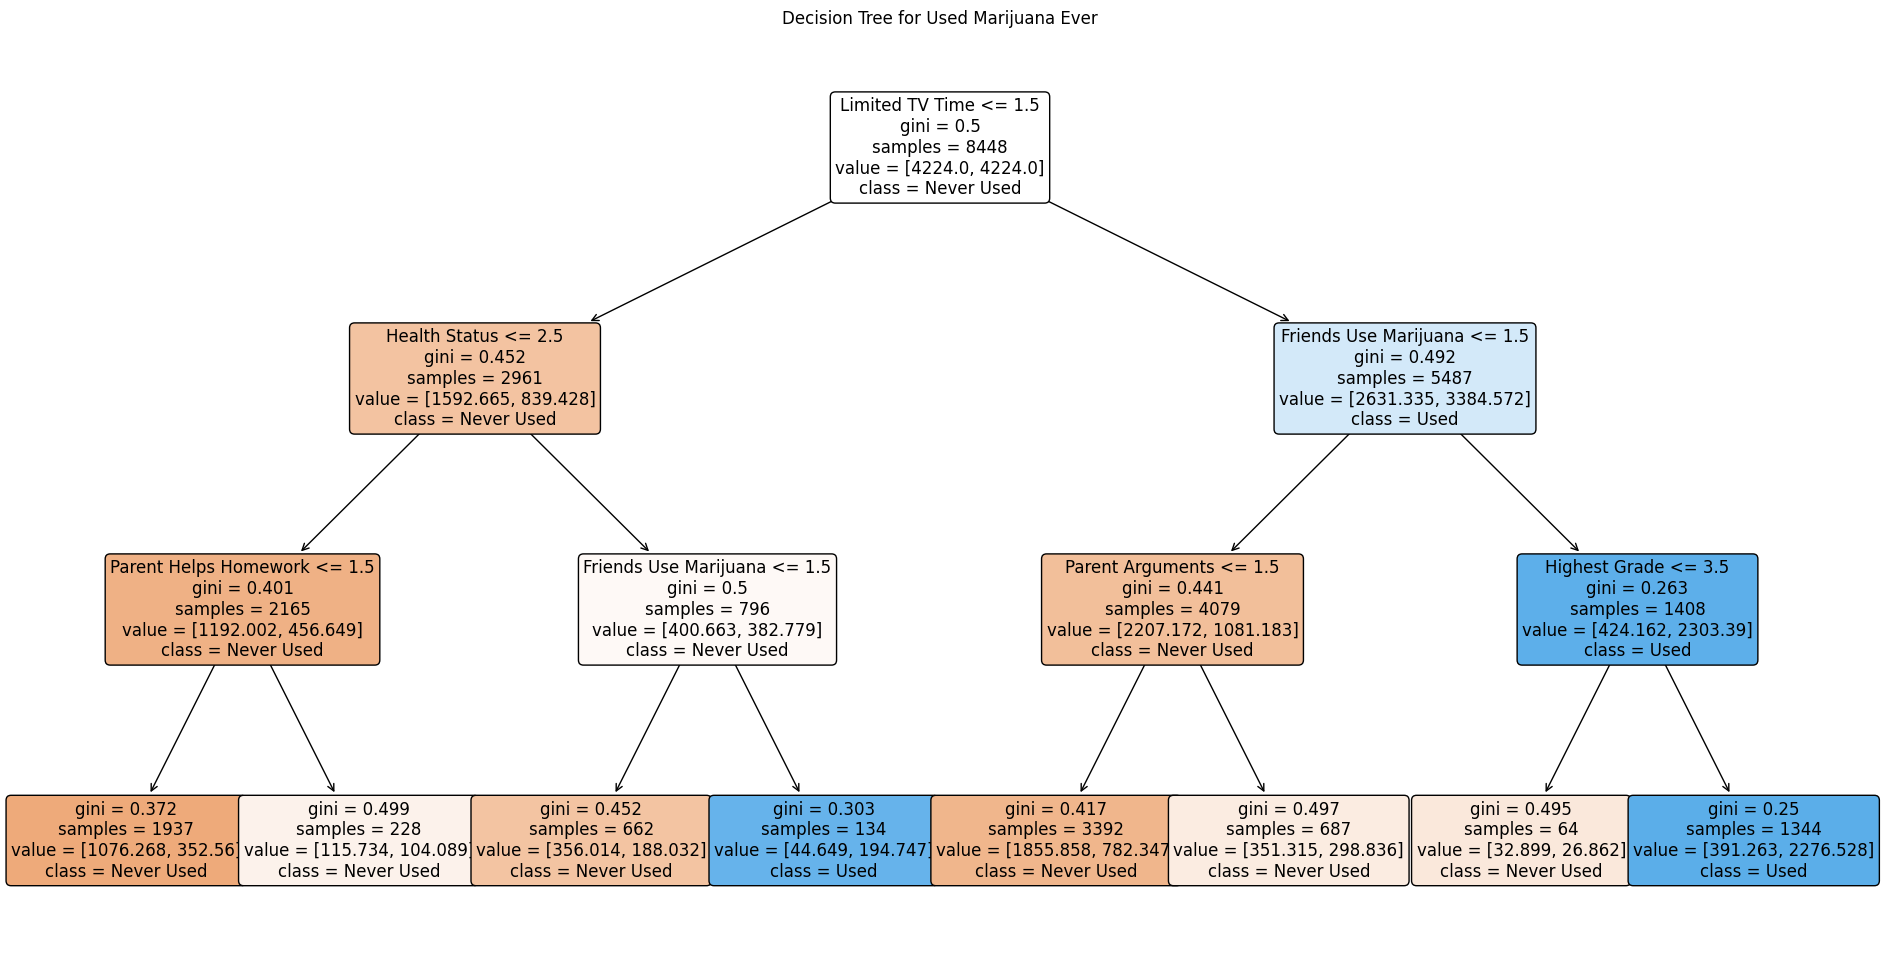

In [21]:
# plot the tree
plt.figure(figsize = (24, 12))
plot_tree(
    decision_tree = best_binary_dt,
    feature_names = x_train.columns.str.replace('_', ' '),
    class_names = ['Never Used', 'Used'],
    filled = True,
    rounded = True,
    fontsize = 12
)
plt.title("Decision Tree for Used Marijuana Ever")
plt.show()

Follow path to bottom left leaf node:

(1) limited tv time in the past year <= 1.5 --> Yes
- 1 = always/sometimes, 2 = seldom/never
- The child's parent(s) limit their tv time always or sometimes
- Go left

(2) health status <= 2.5 --> Yes
- 1 = excellent, 2 = very good, 3 = good, 4 = fair/poor
- Child reports very good or excellent health status score
- Go left

(3) parent helps with homework in the past year <= 1.5 --> Yes
- 1 = always/sometimes, 2 = seldom/never
- The child always or sometimes gets help with homework from their parent(s)
- Go left

(4) leaf node
- Gini index = .372 (moderately pure)
- Samples = 1937
- Value = [1076.268, 352.56]
- Class = Never Used

This means that a student:
- Whose parent(s) always or sometimes limits the amount of tv they can watch
- Who is healthy
- Whose parent(s) always or sometimes helps them with homework\
is very likely to have never used marijuana. 

Of the 1937 individuals who meet the above 3 criteria, roughly 1076 are classified as "never used" marijuana and the 352 are classified as "used" marijuana.\
One thing to note about the tree is that we used class weight = balanced. This means that each traiing instance does not contribute '1' to the sample count. It may contribute less than one or more than 1 depending on its importance.\
So if we look at the first split, we will see 4224, 4224 being sent left and right, but when we look at the left node, only 2961 weighted samples are there. Because our model adds weights to account for class imbalance, some samples might have been down weighted, which is why we are seeing less samples than what is sent from its parent node.\
Gini index indicates some purity, which means that the node is pretty good at separating the two classes. Since 0 is the target for purity, .372 is indicating roughly 70-30 split or 75-25, which is what we see.

## Binary Classification using Bagging

In [22]:
bagging_base = DecisionTreeClassifier(random_state = 5322)
binary_bag = BaggingClassifier(estimator = bagging_base, random_state = 5322)

param_grid = {
    'n_estimators': [10, 50, 75, 100],
    'max_samples': [.7, .75, .8],
    'max_features': [.3, .5, .7, 1],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator = binary_bag,
    param_grid = param_grid,
    cv = cv,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1
)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5322, shuffle=True),
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(random_state=5322),
                                         random_state=5322),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': [0.3, 0.5, 0.7, 1],
                         'max_samples': [0.7, 0.75, 0.8],
                         'n_estimators': [10, 50, 75, 100]},
             scoring='f1', verbose=1)

In [23]:
grid_search.best_params_

{'bootstrap': False,
 'max_features': 0.7,
 'max_samples': 0.8,
 'n_estimators': 75}

In [24]:
best_binary_bag = grid_search.best_estimator_

binary_bag_pred = best_binary_bag.predict(x_test)
print(classification_report(y_test, binary_bag_pred, target_names = ["Never Used", "Used"]))

              precision    recall  f1-score   support

  Never Used       0.88      0.97      0.92      1781
        Used       0.62      0.30      0.41       332

    accuracy                           0.86      2113
   macro avg       0.75      0.63      0.66      2113
weighted avg       0.84      0.86      0.84      2113



Class 0 (No marijuana used ever):
- Precision: .88 --> Of all the people predicted as non-users of marijuana, 88% were actually non-users. This means our model is good at identifying non-users. Few false positives
- Recall: .97 --> Of all the actual non-users, 97% were correctly identified as non-users. This means our model is good at catching non-users, but misses some. Some false negatives.
- F1-score: .92 --> Good balance of precision and recall suggests the model is good at identifying non-users

Class 1 (Used marijuana):
- Precision: .62 --> Of all the people predicted to be users of marijuana, only 62% were actually users. This means the model is not good at identifying users of marijuana. Some false positives
- Recall: .30 --> Of all the actual marijuana users, 30% were correctly identified. This means the model is okay at catching users. Some false negatives.
- F1-score: .41 --> Tries to balance precision and recall, but struggles.

Accuracy: .86 --> 86% is a good accuracy, but again, it is a little midleading since our data has very clear class imbalance. Far more people who have not used versus used, so our model does well on non-users, but very poorly on users.
Decent model, but needs more class 1 data points to improve detecting marijuana users. Overall, did slightly better than the basic decision tree above (the one we used as the base tree).

In [25]:
print(cross_val_score(
    estimator = best_binary_bag,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 0
))
# There is hardly any variance in the f1 cv scores. stable model.

[0.38860104 0.3875969  0.4        0.41860465 0.34920635]


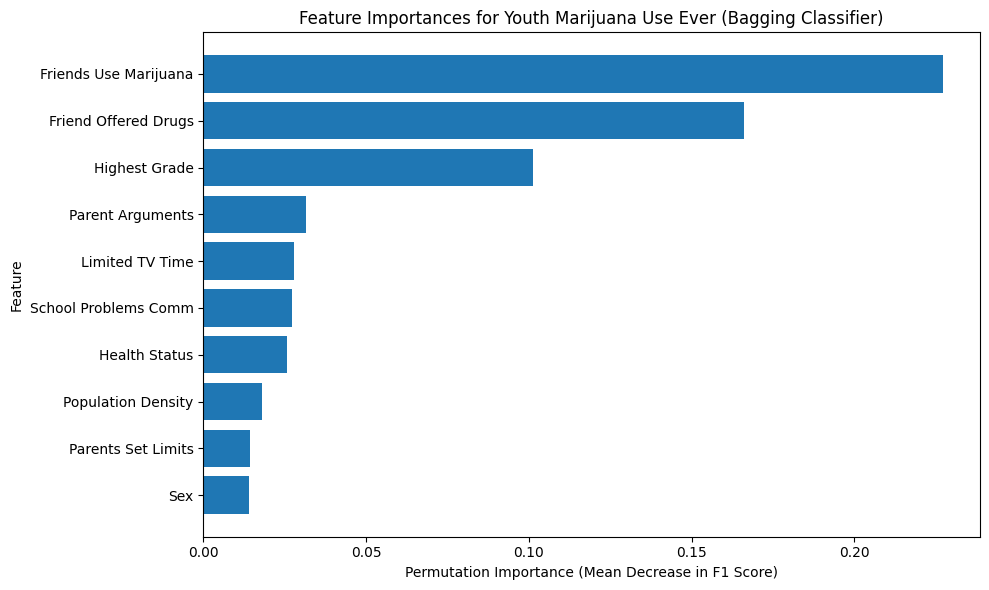

In [26]:
# see which features are most influential
result = permutation_importance(
    estimator = best_binary_bag,
    X = x_test,
    y = y_test,
    scoring = 'f1',
    n_repeats = 10,
    random_state = 5322,
    n_jobs = -1
)

sorted_idx = result.importances_mean.argsort()[::-1]

top_features_raw = [x_test.columns[i] for i in sorted_idx[:10]]
top_features = [feature.replace('_', ' ') for feature in top_features_raw]
top_importances = result.importances_mean[sorted_idx[:10]]

plt.figure(figsize = (10, 6))
plt.barh(top_features[::-1], top_importances[::-1])
plt.title("Feature Importances for Youth Marijuana Use Ever (Bagging Classifier)")
plt.xlabel("Permutation Importance (Mean Decrease in F1 Score)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Even though we did use the best decision tree from earlier as the base tree for this bagging model, there was a bit of a difference in feature importance. Some new ones we see are friend offered drugs, sex, problem solving support, etc. The main difference is friend offered drugs, but nothing surprising or completely out of the blue here either. Similar patterns. Since there was no feature importance attribute for bagging models, I used permutation importance which just sees how much the models performance decreases when the values of a feautre are shuffled or permuted.

## Multiclass Classification using Random Forest Classifier

In [27]:
# split train and test
# create labels for each class
train = data.drop(columns = ['Used_Marijuana_Flag', 'Days_Used_This_Year', 'Days_Used_This_Month'])
bins = [0, 2, 4, 5]
labels = ['Sometimes', 'Addict', 'Never']
test = pd.cut(data['Days_Used_This_Month'], bins = bins, labels = labels)
x_train, x_test, y_train, y_test = train_test_split(train, test, test_size = .2, random_state = 5322)

In [28]:
data['Days_Used_This_Month'].value_counts()

Days_Used_This_Month
5    9809
4     209
3     199
1     195
2     149
Name: count, dtype: int64

In [29]:
# 1 = 1-2 days
# 2 = 3-5 days
# 3 = 6-19 days
# 4 = 20-30 days
# 5 = non-user or no past month use
test.value_counts().sort_index()

Days_Used_This_Month
Sometimes     344
Addict        408
Never        9809
Name: count, dtype: int64

In [30]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10, x_train.shape[1]],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced'],
    'bootstrap': [True, False]
}

multi_rf = RandomForestClassifier(random_state = 5322)
grid_search = GridSearchCV(
    estimator = multi_rf,
    param_grid = param_grid,
    cv = cv,
    n_jobs = -1,
    verbose = 1
)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5322, shuffle=True),
             estimator=RandomForestClassifier(random_state=5322), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': [None, 'balanced'],
                         'max_depth': [3, 5, 10, 32],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [100, 200]},
             verbose=1)

In [31]:
grid_search.best_params_

{'bootstrap': False,
 'class_weight': None,
 'max_depth': 32,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [32]:
# optimal model & results
best_multi_rf = grid_search.best_estimator_

multi_pred = best_multi_rf.predict(x_test)
print(classification_report(y_test, multi_pred, zero_division = 0))

              precision    recall  f1-score   support

      Addict       0.50      0.04      0.07        78
       Never       0.93      1.00      0.96      1954
   Sometimes       0.50      0.01      0.02        81

    accuracy                           0.92      2113
   macro avg       0.64      0.35      0.35      2113
weighted avg       0.89      0.92      0.89      2113



Again, there is class imbalance

Addict:
- Precision: .50 --> Of all the predictions labeled "Addict", only 50% were addicts. Our model is terrible (same as flipping a coin to determine outcome) at identifying addicts. A lot of false positives.
- Recall: .04 --> Of all the true "Addict" cases, only 4% were correctly identified. Almost all addicts were missed. A lot of false negatives
- F1-score: .07 --> Model fails to identify addicts

Never:
- Precision: .93 --> Of all the predictions labeled "Never", 93% were those who have never used marijuana. Model is amazing at identifying non-users (or users that have not used in the past 30 days). Hardly any false positives
- Recall: 1.00 --> Of all the true "Never" cases, 100% were correctly identified. All non-users and not-used-in-past-30-days were correctly identified. No false negatives.
- F1-score: .96 --> Good balance of precision and recall for non-users and not-used-in-past-30-days people.

Sometimes:
- Precision: .50 --> The model did not predict "Sometimes" at all.
- Recall: .01 --> None of the actual "Sometimes" people were correctly identified since there were no predictions.
- F1-score: .02 --> Model failed to identify "Sometimes" users.

Accuracy: .92 --> Good accuracy, but again, misleading. Due to our data having a clear class imbalance, our model is only very good at identifying those who have not used marijuana ever or those who have not used marijuana in the past 30 days.

In [33]:
print(cross_val_score(
    estimator = best_multi_rf,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'f1_weighted',
    n_jobs = -1,
    verbose = 0
))
# There is hardly any variance in the f1 cv scores. stable model.

[0.89562181 0.89755115 0.89818152 0.90260695 0.90441495]


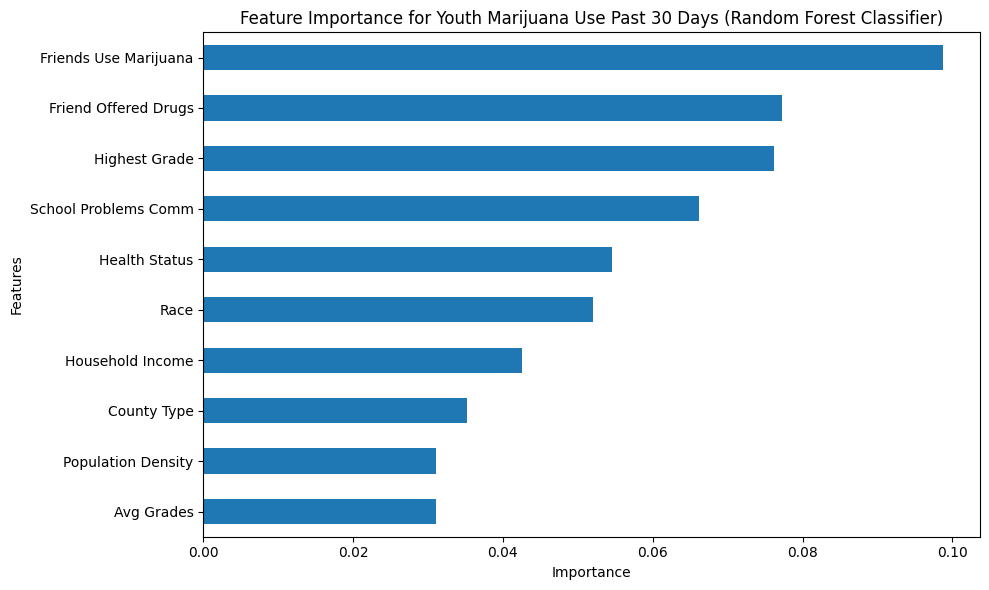

In [34]:
# see which features are most influential
importances = pd.Series(
    best_multi_rf.feature_importances_, 
    index = x_train.columns.str.replace('_', ' ')
).sort_values(ascending = True)

plt.figure(figsize = (10, 6))
importances.tail(10).plot(kind = 'barh')
plt.title("Feature Importance for Youth Marijuana Use Past 30 Days (Random Forest Classifier)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

We see similar features here as well. Like the other models, friends use marijuana and friend offered drugs seem to be the big features of influence. (So are they really your friends lol). Highest grade and race are somewhat new ones. Not really surprised here either. Pretty intuitive because of all those middle and high school assemblies and papers we had to write about drug use stuff.

## Multiclass Classification using Decision Tree

In [35]:
# split train and test data
# create labels for each class
train = data.drop(columns = ['Used_Marijuana_Flag', 'Days_Used_This_Year', 'Days_Used_This_Month'])
bins = [0, 2, 4, 5]
labels = ['Sometimes', 'Addict', 'Never']
test = pd.cut(data['Days_Used_This_Month'], bins = bins, labels = labels)
x_train, x_test, y_train, y_test = train_test_split(train, test, test_size = .2, random_state = 5322)

In [36]:
param_grid = {
    'max_depth': [3, 5, 10, 20, x_train.shape[1]],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

multi_dt = DecisionTreeClassifier(random_state = 5322)
grid_search = GridSearchCV(
    estimator = multi_dt,
    param_grid = param_grid,
    cv = cv,
    scoring = 'f1_weighted',
    n_jobs = -1,
    verbose = 1
)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5322, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=5322), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [3, 5, 10, 20, 32],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 5, 10]},
             scoring='f1_weighted', verbose=1)

In [37]:
grid_search.best_params_

{'class_weight': None,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [38]:
best_multi_dt = grid_search.best_estimator_

multi_dt_pred = best_multi_dt.predict(x_test)
print(classification_report(y_test, multi_dt_pred))

              precision    recall  f1-score   support

      Addict       0.18      0.17      0.17        78
       Never       0.94      0.97      0.95      1954
   Sometimes       0.50      0.05      0.09        81

    accuracy                           0.91      2113
   macro avg       0.54      0.40      0.41      2113
weighted avg       0.89      0.91      0.89      2113



Again, there is class imbalance.

Addict:
- Precision: .18 --> Of all the predictions labeled "Addict", only 18% were addicts. Our model is terrible (worse than flipping a coin to determine outcome) at identifying addicts. A lot of false positives.
- Recall: .17 --> Of all the true "Addict" cases, only 17% were correctly identified. Almost all addicts were missed. A lot of false negatives.
- F1-score: .17 --> Model fails to identify addicts.

Never:
- Precision: .94 --> Of all the predictions labeled "Never", 94% were those who have never used marijuana. Model is amazing at identifying non-users (or users that have not used in the past 30 days). Hardly any false positives.
- Recall: .97 --> Of all the true "Never" cases, 97% were correctly identified. All non-users and not-used-in-past-30-days were correctly identified. A couple false negatives.
- F1-score: .95 --> Good balance of precision and recall for non-users and not-used-in-past-365-days people.

Sometimes:
- Precision: .50 --> Of all the predictions labeled "Sometimes", only 50% were those who used marijuana "Sometimes". Model is terrible at identifying these people. A lot of false positives.
- Recall: .05 --> Of all the true "Sometimes" cases, 5% were correctly identified. Basically all "Sometimes" cases were missed. A lot of false negatives.
- F1-score: .09 --> Model failed to identify "Sometimes" users.

Accuracy: .91 --> Good accuracy, but again, misleading. Due to our data having a clear class imbalance, our model is only very good at identifying those who have not used marijuana ever or those who have not used marijuana in the past 30 days. However, it did do better than the random forest surprisingly.

In [39]:
print(cross_val_score(
    estimator = best_multi_dt,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'f1_weighted',
    n_jobs = -1,
    verbose = 0
))
# There is hardly any variance in the f1 cv scores. stable model.

[0.89681483 0.89582036 0.90431942 0.89679452 0.90211062]


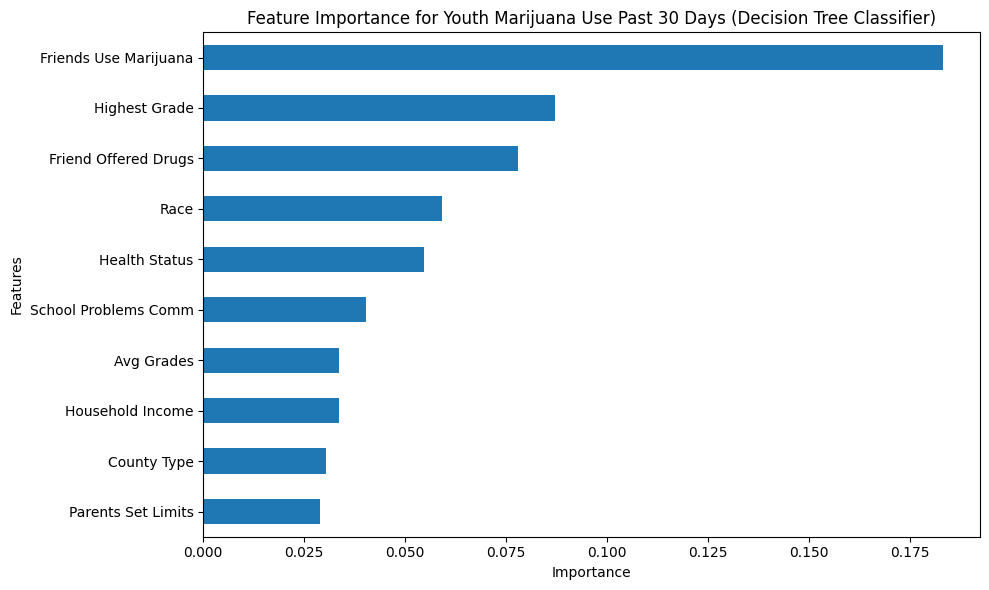

In [40]:
# see which features are most influential
importances = pd.Series(
    best_multi_dt.feature_importances_, 
    index = x_train.columns.str.replace('_', ' ')
).sort_values(ascending = True)

plt.figure(figsize = (10, 6))
importances.tail(10).plot(kind = 'barh')
plt.title("Feature Importance for Youth Marijuana Use Past 30 Days (Decision Tree Classifier)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

## Regression with Boosting

Since 'Days_Used_This_Year' is more a discrete variable than continuous, I decided to use the midpoints of the ranges to be representative of the class. This way, we get a continuous prediciton for the number of days used in the past year rather than just a class (which is just multiclassification)

In [41]:
# 1 = 1-11 days
# 2 = 12-49 days
# 3 = 50-99 days
# 4 = 100-299 days
# 5 = 300-365 days
# 6 = non-user or no past year use
midpoints = {
    1 : 6,
    2: 30.5,
    3: 74.5,
    4: 199.5,
    5: 332.5,
    6: 0
}

In [42]:
# split train and test
# map the midpoints to their group to make target variable more continuous than discrete
train = data.drop(columns = ['Used_Marijuana_Flag', 'Days_Used_This_Year', 'Days_Used_This_Month'])
test = data['Days_Used_This_Year'].map(midpoints)
x_train, x_test, y_train, y_test = train_test_split(train, test, test_size = .2, random_state = 5322)

In [43]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [.01, .05, .1],
    'max_depth': [3, 5, 7],
    'subsample': [.6, .7, .8],
    'min_samples_split': [2, 5, 10, x_train.shape[1]]
}

reg_gboost = GradientBoostingRegressor(random_state = 5322)
cv = KFold(n_splits = 5, shuffle = True, random_state = 5322)
grid_search = GridSearchCV(
    estimator = reg_gboost,
    param_grid = param_grid,
    cv = cv,
    scoring = 'r2',
    n_jobs = -1,
    verbose = 1
)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=5322, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=5322), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 10, 32],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2', verbose=1)

In [44]:
grid_search.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 500,
 'subsample': 0.6}

In [45]:
best_gboost = grid_search.best_estimator_

gboost_pred = best_gboost.predict(x_test)
r2 = r2_score(y_test, gboost_pred)
rmse = mean_squared_error(y_test, gboost_pred) ** .5
r2, rmse

(0.1356443666124274, 41.90689050733329)

In [46]:
print(cross_val_score(
    estimator = best_gboost,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'r2',
    n_jobs = -1,
    verbose = 0
))
# There is hardly any variance in the r2 cv scores. stable model.

[0.14247385 0.17114989 0.16726508 0.1857486  0.14297673]


In [47]:
print(np.sqrt(-cross_val_score(
    estimator = best_gboost,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    verbose = 0
)))
# There is hardly any variance in the RMSE cv scores. stable model.

[45.4206158  50.0687096  48.09861783 42.8004598  42.6677952 ]


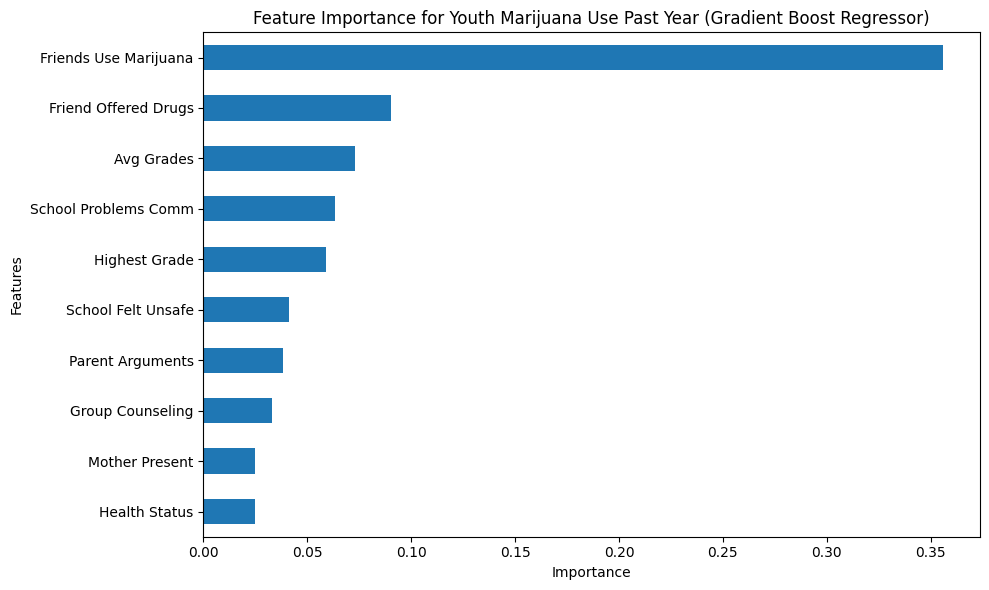

In [48]:
# see which features are most influential
importances = pd.Series(
    best_gboost.feature_importances_, 
    index = x_train.columns.str.replace('_', ' ')
).sort_values(ascending = True)

plt.figure(figsize = (10, 6))
importances.tail(10).plot(kind = 'barh')
plt.title("Feature Importance for Youth Marijuana Use Past Year (Gradient Boost Regressor)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [49]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.7, 0.8],
    'min_child_weight': [1, 3, 5]  # Equivalent to controlling model complexity like min_samples_split
}

reg_xgboost = XGBRegressor(objective = 'reg:squarederror', random_state = 5322)
grid_search = GridSearchCV(
    estimator = reg_xgboost,
    param_grid = param_grid,
    cv = cv,
    scoring = 'r2',
    n_jobs = -1,
    verbose = 1
)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=5322, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    in...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=5322, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.6, 0.7, 0.8]},
             scoring='r2', verbose=1)

In [50]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 0.6}

In [51]:
best_reg_xgboost = grid_search.best_estimator_

reg_xgboost_pred = best_reg_xgboost.predict(x_test)

r2 = r2_score(y_test, reg_xgboost_pred)
rmse = mean_squared_error(y_test, reg_xgboost_pred) ** .5
r2, rmse

(0.13547864024158363, 41.91090780284159)

In [52]:
print(cross_val_score(
    estimator = best_reg_xgboost,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'r2',
    n_jobs = -1,
    verbose = 0
))
# There is hardly any variance in the r2 cv scores. stable model.

[0.15211759 0.17277921 0.16943188 0.18693901 0.15410885]


In [53]:
print(np.sqrt(-cross_val_score(
    estimator = best_reg_xgboost,
    X = x_train,
    y = y_train,
    cv = cv,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    verbose = 0
)))
# There is hardly any variance in the RMSE cv scores. stable model.

[45.16449346 50.01947377 48.03600005 42.76916195 42.38977733]


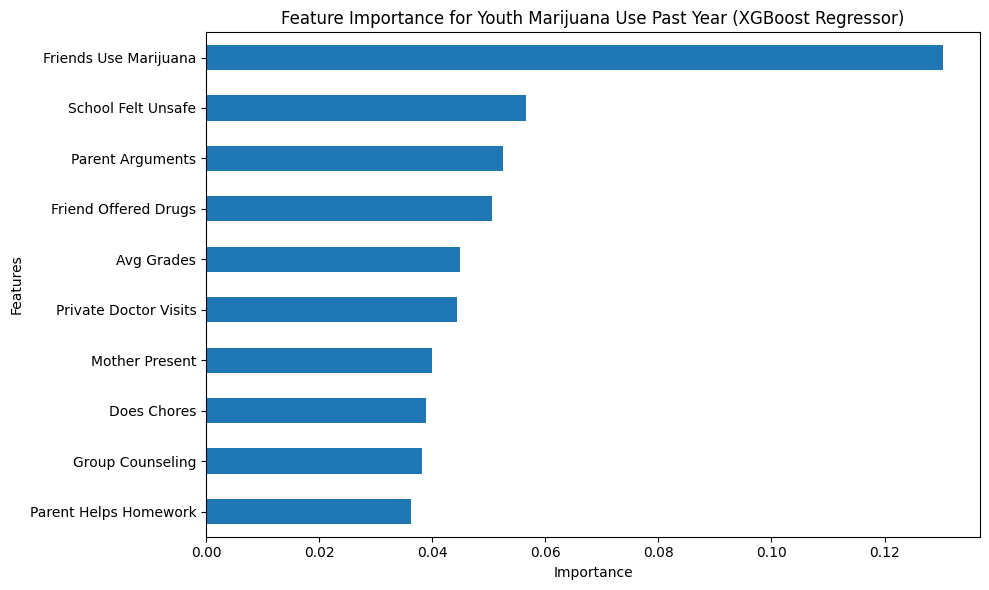

In [54]:
# see which features are most influential
importances = pd.Series(
    best_reg_xgboost.feature_importances_, 
    index = x_train.columns.str.replace('_', ' ')
).sort_values(ascending = True)

plt.figure(figsize = (10, 6))
importances.tail(10).plot(kind = 'barh')
plt.title("Feature Importance for Youth Marijuana Use Past Year (XGBoost Regressor)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

## Final Thoughts

- Peer-related features (especially marijuana use among friends) were the most predictive across all models. Pretty intuitive.
- Models struggled more with identifying marijuana users due to class imbalance.
- Future work might involve resampling or feature selection techniques to refine predictors with interaction terms maybe.